In [1]:
# -*- coding: utf-8 -*-
"""ECS289G-Deep Learning Homework Set in Fall 2020.

This notebook composes the solution for Fall 2020 ECS289G Deep Learning course homework set.

Author:
    Fangzhou Li - fzli@ucdavis.edu

"""

from os import path
from matplotlib import pyplot as plt
from matplotlib import patches
import pickle
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegressionCV
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_similarity
from tensorflow.keras import layers, Model
from tqdm import tqdm
import numpy as np
import matplotlib
import tensorflow as tf


In [151]:
# 1. Math Problems

def dfx(point):
    return np.dot(point, [2, 1])

def dfy(point):
    return np.dot(point, [1, 12])

p_0 = np.array([4, 1])
v_0 = np.array([0, 0])
alpha = 0.05
gamma = 0.9
n_iter = 50
i_print = [4, 9, 49]

def sgd_step(point):
    return point - alpha * np.array([dfx(point), dfy(point)])

def momentum_step(point, v):
    v_new = gamma * v - alpha * np.array([dfx(point), dfy(point)])
    p_new = point + v_new
    return p_new, v_new

def nag_step(point, v):
    v_new = gamma * v - alpha * np.array([dfx(point + gamma * v), dfy(point + gamma * v)])
    p_new = point + v_new
    return p_new, v_new

# SGD
print("Start SGD...")
p = p_0
v = v_0
for i in range(n_iter):
    p, v = sgd_step(p)
    if i in i_print:
        print("{}th iteration's distance to the optimal: {}".format(i+1, np.sum(p ** 2) ** 0.5))
print()

# Classical Momentum
print("Start CM...")
p = p_0
v = v_0
for i in range(n_iter):
    p, v = momentum_step(p, v)
    if i in i_print:
        print("{}th iteration's distance to the optimal: {}".format(i+1, np.sum(p ** 2) ** 0.5))
print()

# NAG
print("Start NAG...")
p = p_0
v = v_0
for i in range(n_iter):
    p, v = nag_step(p, v)
    if i in i_print:
        print("{}th iteration's distance to the optimal: {}".format(i+1, np.sum(p ** 2) ** 0.5))

# Observation: With a small number of iterations, CM and NAG perform way better than SGD. This
#   shows that momentum can approach to the minimum quicker. With a high iteration, however, SGD
#   somehow approches to the minumum better than the others. I think this is due to the function.
#   Overall, NAG does not perform badly in any iterations, while SGD performs badly with small
#   iterations and CM performs badly with medium iterations occasionaly.


Start SGD...
5th iteration's distance to the optimal: 2.0639921875
10th iteration's distance to the optimal: 1.570373779378954
50th iteration's distance to the optimal: 0.0069310653811040035

Start CM...
5th iteration's distance to the optimal: 0.30027682831472996
10th iteration's distance to the optimal: 2.3585895482968837
50th iteration's distance to the optimal: 0.2937882354390843

Start NAG...
5th iteration's distance to the optimal: 0.442870907161429
10th iteration's distance to the optimal: 1.3778340202947361
50th iteration's distance to the optimal: 0.021268420880687276


In [2]:
# 2. Applied Problems
# numpy, pandas, scikit-learn, keras, tensorflow, matplotlib, seaborn are allowed.


In [3]:
# 2.1. Text

NUM_WORDS = 5000

# Load vocabulary, reference: https://stackoverflow.com/questions/42821330/\
#   restore-original-text-from-keras-s-imdb-dataset
word_index = tf.keras.datasets.imdb.get_word_index(
    path="imdb_word_index.json")
word_index = {k:(v - 1) for k, v in word_index.items()}
index_word = {v:k for k, v in word_index.items()}

index_word = {i: index_word[i] for i in range(NUM_WORDS)}
word_index = {index_word[k]: k for k in index_word.keys()}

def clean_corpus(corpus):
    """
    
    """
    return [i - 4 for i in corpus if i - 4 > -1]

def get_corpus_seq(corpus):
    """
    
    """
    return [index_word[i] for i in corpus]

# Load IMDB data with 5000 most frequent words.
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.imdb.load_data(
    path='imdb.npz',
    num_words=NUM_WORDS,
    skip_top=0,
    maxlen=None,
    seed=113,
    start_char=1,
    oov_char=2,
    index_from=3)
x_train = [clean_corpus(corpus) for corpus in x_train]
x_test = [clean_corpus(corpus) for corpus in x_test]

print(get_corpus_seq(x_train[0]))


<__array_function__ internals>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/home/fzli/anaconda3/envs/tf/lib/python3.8/site-packages/tensorflow/python/keras/datasets/imdb.py:159: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_train, y_train = np.array(xs[:idx]), np.array(labels[:idx])
/home/fzli/anaconda3/envs/tf/lib/python3.8/site-packages/tensorflow/python/keras/datasets/imdb.py:160: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes)

['this', 'film', 'was', 'just', 'brilliant', 'casting', 'location', 'scenery', 'story', 'direction', "everyone's", 'really', 'suited', 'the', 'part', 'they', 'played', 'and', 'you', 'could', 'just', 'imagine', 'being', 'there', 'robert', 'is', 'an', 'amazing', 'actor', 'and', 'now', 'the', 'same', 'being', 'director', 'father', 'came', 'from', 'the', 'same', 'scottish', 'island', 'as', 'myself', 'so', 'i', 'loved', 'the', 'fact', 'there', 'was', 'a', 'real', 'connection', 'with', 'this', 'film', 'the', 'witty', 'remarks', 'throughout', 'the', 'film', 'were', 'great', 'it', 'was', 'just', 'brilliant', 'so', 'much', 'that', 'i', 'bought', 'the', 'film', 'as', 'soon', 'as', 'it', 'was', 'released', 'for', 'and', 'would', 'recommend', 'it', 'to', 'everyone', 'to', 'watch', 'and', 'the', 'fly', 'was', 'amazing', 'really', 'cried', 'at', 'the', 'end', 'it', 'was', 'so', 'sad', 'and', 'you', 'know', 'what', 'they', 'say', 'if', 'you', 'cry', 'at', 'a', 'film', 'it', 'must', 'have', 'been', 'g

In [4]:
# 2.1.1. Visualization. 

# Pick first 500 positive and 500 negative training samples.
x_train_pos = []
x_train_neg = []
        
i = 0
while True:
    if y_train[i] == 1 and len(x_train_pos) < 500:  # pos
        x_train_pos.append(x_train[i])
    if y_train[i] == 0 and len(x_train_neg) < 500:  # neg
        x_train_neg.append(x_train[i])
    if len(x_train_pos) == 500 and len(x_train_neg) == 500:
        break
    i += 1

print(len(x_train_pos), len(x_train_neg))  # 500 500


500 500


In [5]:
# Vectorize each document by TF-IDF.
vectorizer = TfidfVectorizer(token_pattern=r'[^\s]+', vocabulary=word_index)
corpuses_content = [' '.join(get_corpus_seq(x)) for x in x_train_pos + x_train_neg]
X_tfidf = vectorizer.fit_transform(corpuses_content)
print("(n_corpuses, n_words) =", X_tfidf.shape)


(n_corpuses, n_words) = (1000, 5000)


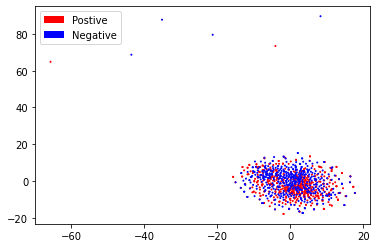

In [6]:
# Visualize by T-SNE.
tsne = TSNE(n_components=2, random_state=2, n_jobs=-1)
X_tfidf_tsne = tsne.fit_transform(X_tfidf)

plt.scatter(
    x=X_tfidf_tsne[:, 0],
    y=X_tfidf_tsne[:, 1],
    s=[1] * 1000,
    c=['red'] * 500 + ['blue'] * 500)
plt.legend([patches.Rectangle((0,0), 1, 1, fc='red'),
            patches.Rectangle((0,0), 1, 1, fc='blue')],
           ['Postive', 'Negative'])
plt.show()

# Comment: By TF-IDF word embedding, positive and negative data points tend to coalesce
#   to one group. This may suggest that by word and document frequencies alone, it is
#   not good enough to separate sentiments in the corpuses.


In [7]:
# 2.1.2. Baseline models.

X = vectorizer.fit_transform(' '.join(get_corpus_seq(x)) for x in x_train)
y = y_train

clf_acc = LogisticRegressionCV(Cs=1, cv=10, scoring='accuracy', n_jobs=-1)
clf_f1 = LogisticRegressionCV(Cs=1, cv=10, scoring='f1', n_jobs=-1)
clf_acc.fit(X, y)
clf_f1.fit(X, y)

print("Average accuracy:", clf_acc.scores_[1].mean())
print("Average F1 score:", clf_f1.scores_[1].mean())


Average accuracy: 0.7637599999999999
Average F1 score: 0.7682889098947975


In [20]:
# 2.1.3. Embeddings.

class Word2VecModelDataGenerator(tf.keras.utils.Sequence):
    """Data generator for W2V model for the limited memory issue.
    
    Reference: https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly
    """

    def __init__(self, targets, contexts, labels, batch_size=32, shuffle=True):
        self.targets = targets
        self.contexts = contexts
        self.labels = labels
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.on_epoch_end()
        
    def __len__(self):
        """The number of batches per epoch.
        
        """
        return len(self.targets) // self.batch_size
    
    def __getitem__(self, index):
        """Generate one batch of data.
        
        """
        indices = self.indices[index * self.batch_size:(index + 1) * self.batch_size]
        
        targets = np.empty((self.batch_size, 1), dtype=np.int64)
        contexts = np.empty((self.batch_size, len(self.contexts[0])), dtype=np.int64)
        y = np.empty((self.batch_size, len(self.contexts[0])), dtype=np.int64)        
        for i in range(len(indices)):
            targets[i] = self.targets[indices[i]]
            contexts[i, :] = self.contexts[indices[i]]
            y[i] = self.labels[indices[i]]
        X = (targets, contexts)
        return X, y
    
    def on_epoch_end(self):
        """Update indices after each epoch.
        
        """
        self.indices = np.arange(len(self.targets))
        if self.shuffle:
            np.random.shuffle(self.indices)


# Implement a Skip-gram Word2Vec model.
class Word2VecModelPreprocessor:
    """W2V model data preprocessor.
    
    Reference: https://www.tensorflow.org/tutorials/text/word2vec
    
    """

    def __init__(self, dim_output, window_size, vocab_size, n_neg):
        self.dim_output = dim_output
        self.window_size = window_size
        self.vocab_size = vocab_size
        self.n_neg = n_neg
    
    def generate_pos_skip_grams(self, corpus, sampling_table):
        """

        """
        pos_skip_grams, _ = tf.keras.preprocessing.sequence.skipgrams(
            corpus,
            vocabulary_size=self.vocab_size,
            sampling_table=sampling_table,
            window_size=self.window_size,
            negative_samples=0)
        return pos_skip_grams
    
    def generate_neg_samples(self, classes_context):
        """
        
        """
        indices_negative_samples, _, _ = tf.random.log_uniform_candidate_sampler(
            true_classes=classes_context,
            num_true=1,
            num_sampled=self.n_neg,
            unique=True,
            range_max=self.vocab_size,
            name="negative_sampling")
        return indices_negative_samples
    
    def generate_training_data(self, corpuses):
        """
        
        """
        targets, contexts, labels = [], [], []

        sampling_table = tf.keras.preprocessing.sequence.make_sampling_table(self.vocab_size)
        
        for corpus in tqdm(corpuses):
            pos_skip_grams = self.generate_pos_skip_grams(corpus, sampling_table)
            for idx_word_target, idx_word_context in pos_skip_grams:
                classes_context = tf.expand_dims(
                    tf.constant([idx_word_context], dtype='int64'), 1)
                indices_negative_samples = self.generate_neg_samples(classes_context)
                
                indices_negative_samples = tf.expand_dims(indices_negative_samples, 1)
                context = tf.concat([classes_context, indices_negative_samples], 0)
                label = tf.constant([1] + [0] * self.n_neg, dtype='int64')

                targets.append(tf.squeeze(idx_word_target))
                contexts.append(tf.squeeze(context))
                labels.append(tf.squeeze(label))
        return targets, contexts, labels


class Word2VecModel(Model):
    """
    
    """
    
    def __init__(self, dim_output, dim_embedding):
        super().__init__()
        self.dim_embedding = dim_embedding
        self.dim_output = dim_output
        
        self.target_embedding = layers.Embedding(
            self.dim_output, self.dim_embedding, name='w2v_embedding')
        self.context_embedding = layers.Embedding(
            self.dim_output, self.dim_embedding)
        self.dots = layers.Dot(axes=(2, 2))
        self.flatten = layers.Flatten()

    def call(self, X):
        target, context = X
        target_embedding = self.target_embedding(target)
        context_embedding = self.context_embedding(context)
        dots = self.dots([context_embedding, target_embedding])
        return self.flatten(dots)


In [9]:
# Get training data.
DIM_OUTPUT = NUM_WORDS
VOCAB_SIZE = NUM_WORDS
WINDOW_SIZE = 2
N_NEG = 5
N_SAMPLES = 25000

X = x_train[:N_SAMPLES]
targets, contexts, labels = Word2VecModelPreprocessor(
    dim_output=DIM_OUTPUT,
    window_size=WINDOW_SIZE,
    vocab_size=VOCAB_SIZE,
    n_neg=N_NEG).generate_training_data(X)

print("The number of data: {}".format(len(targets)))
print("The first target  : {}".format(get_corpus_seq([targets[0].numpy()])[0]))
print("The first context : {}".format(get_corpus_seq(contexts[0].numpy())))
print("The first corpus  :")
print(get_corpus_seq(X[0]))


100%|██████████| 25000/25000 [05:03<00:00, 82.26it/s] 

The number of data: 2386369
The first target  : were
The first context : ['just', 'be', 'from', 'year', 'one', 'not']
The first corpus  :
['this', 'film', 'was', 'just', 'brilliant', 'casting', 'location', 'scenery', 'story', 'direction', "everyone's", 'really', 'suited', 'the', 'part', 'they', 'played', 'and', 'you', 'could', 'just', 'imagine', 'being', 'there', 'robert', 'is', 'an', 'amazing', 'actor', 'and', 'now', 'the', 'same', 'being', 'director', 'father', 'came', 'from', 'the', 'same', 'scottish', 'island', 'as', 'myself', 'so', 'i', 'loved', 'the', 'fact', 'there', 'was', 'a', 'real', 'connection', 'with', 'this', 'film', 'the', 'witty', 'remarks', 'throughout', 'the', 'film', 'were', 'great', 'it', 'was', 'just', 'brilliant', 'so', 'much', 'that', 'i', 'bought', 'the', 'film', 'as', 'soon', 'as', 'it', 'was', 'released', 'for', 'and', 'would', 'recommend', 'it', 'to', 'everyone', 'to', 'watch', 'and', 'the', 'fly', 'was', 'amazing', 'really', 'cried', 'at', 'the', 'end', 'it'

In [121]:
# Store the training data into a local file.
targets = np.array([target.numpy() for target in tqdm(targets)])
contexts = np.array([context.numpy() for context in tqdm(contexts)])
labels = np.array([label.numpy() for label in tqdm(labels)])

with open("data/w2v_train.pkl", 'wb') as f:
    pickle.dump((targets, contexts, labels), f)


In [19]:
with open("data/w2v_train.pkl", 'rb') as f:
    tagrets, contexts, labels = pickle.load(f)


In [157]:
# Train the W2V model.
DIM_EMBEDDING = 32
EPOCHS = 5
BATCH_SIZE = 1024
ALPHA = 0.01

w2v_data_generator = Word2VecModelDataGenerator(
    targets=targets,
    contexts=contexts,
    labels=labels,
    batch_size=BATCH_SIZE)
w2v = Word2VecModel(
    dim_embedding=DIM_EMBEDDING,
    dim_output=DIM_OUTPUT)
w2v.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=ALPHA),
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'])
w2v.fit(w2v_data_generator, epochs=EPOCHS)
w2v.save('models/word2vec')


Epoch 1/5
2330/2330 [==============================] - 13s 6ms/step - loss: 1.5789 - accuracy: 0.3514
Epoch 2/5
2330/2330 [==============================] - 13s 6ms/step - loss: 1.5024 - accuracy: 0.3975
Epoch 3/5
2330/2330 [==============================] - 13s 6ms/step - loss: 1.4875 - accuracy: 0.4049
Epoch 4/5
2330/2330 [==============================] - 15s 7ms/step - loss: 1.4818 - accuracy: 0.4079
Epoch 5/5
2330/2330 [==============================] - 15s 6ms/step - loss: 1.4790 - accuracy: 0.4089
INFO:tensorflow:Assets written to: models/word2vec/assets


In [158]:
# Get W2V embeddings.
w2v_embeddings = w2v.get_layer('w2v_embedding').get_weights()[0]
print("(n_vocab, dim_embedding) = ({}, {})".format(len(w2v_embeddings), len(w2v_embeddings[0])))


(n_vocab, dim_embedding) = (5000, 32)


['movie', 'film', 'turkey', 'review', 'mess', 'crap', 'stinker', 'junk', 'thing', 'gem']


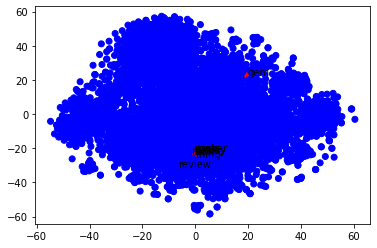

In [159]:
# Plot T-SNE for word embeddings. Annotate 10 similar words.
NUM_SHOW = 10
WORD_SHOW = 'movie'

def find_similarity(word_embeddings, word, n_samples):
    """
    
    Args:
        word_embeddings (np.numpy): The word embedding matrix.
        word (str): Find the words that are similar to this word.
        n_samples (int): Returns the most similar n_samples word indices.
    
    Returns:
        (list of int): The n_samples indices of similar words.

    """
    scores = cosine_similarity([word_embeddings[word_index[word]]], word_embeddings)
    return np.argsort(scores[0])[::-1][:n_samples]

word_indices_similar = find_similarity(w2v_embeddings, WORD_SHOW, NUM_SHOW)
tsne = TSNE(n_components=2, random_state=1, n_jobs=-1)
X_tsne_w2v = tsne.fit_transform(w2v_embeddings)
x = X_tsne_w2v[:, 0]
y = X_tsne_w2v[:, 1]
c = ['blue'] * len(x)
for i in word_indices_similar:
    c[i] = 'red'

fig, ax = plt.subplots()
ax.scatter(
    x=x,
    y=y,
    c=c)
for i in word_indices_similar:
    ax.annotate(index_word[i], (x[i], y[i]))
print(get_corpus_seq(word_indices_similar))
plt.show()


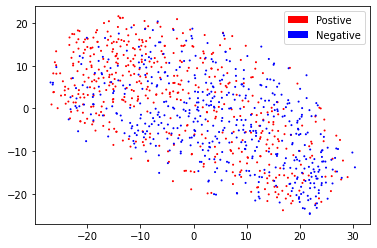

In [160]:
# Plot T-SNE for corpus samples.
X = x_train_pos + x_train_neg
y = [1] * len(x_train_pos) + [0] * len(x_train_neg)

X_corpus_embedding = np.empty((len(X), DIM_EMBEDDING))
for i in range(len(X)):
    vec_sum = np.array([0.0] * 32)
    for idx_word in X[i]:
        vec_sum += w2v_embeddings[idx_word]
    X_corpus_embedding[i] = vec_sum / len(X[i])

tsne = TSNE(n_components=2, random_state=1, n_jobs=-1)
X_tsne_corpus_embedding = tsne.fit_transform(X_corpus_embedding)

plt.scatter(
    x=X_tsne_corpus_embedding[:, 0],
    y=X_tsne_corpus_embedding[:, 1],
    s=[1] * 1000,
    c=['red'] * 500 + ['blue'] * 500)
plt.legend([patches.Rectangle((0,0), 1, 1, fc='red'),
            patches.Rectangle((0,0), 1, 1, fc='blue')],
           ['Postive', 'Negative'])
plt.show()


In [161]:
# Logistic regression with Word2Vec.
X = x_train[:N_SAMPLES]
y = y_train[:N_SAMPLES]

X_embedded = np.empty((len(X), DIM_EMBEDDING))
for i in range(len(X)):
    vec_sum = np.array([0.0] * 32)
    for idx_word in X[i]:
        vec_sum += w2v_embeddings[idx_word]
    X_embedded[i] = vec_sum / len(X[i])

clf_acc = LogisticRegressionCV(Cs=1, cv=10, scoring='accuracy', n_jobs=-1)
clf_f1 = LogisticRegressionCV(Cs=1, cv=10, scoring='f1', n_jobs=-1)
clf_acc.fit(X_embedded, y)
clf_f1.fit(X_embedded, y)

print("Average accuracy:", clf_acc.scores_[1].mean())
print("Average F1 score:", clf_f1.scores_[1].mean())


Average accuracy: 0.65188
Average F1 score: 0.6490790621296189


In [162]:
# 2.1.4. RNN.

# Define classes for RNN.
class RNNWithW2VDataGenerator(tf.keras.utils.Sequence):
    """Data generator for RNN+W2V model for the limited memory issue.
    
    Reference: https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly
    """

    def __init__(self, X, y, embeddings, batch_size=32, shuffle=True):
        self.X = X
        self.y = y
        self.embeddings = embeddings
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.on_epoch_end()
        
    def __len__(self):
        """The number of batches per epoch.
        
        """
        return len(self.X) // self.batch_size
    
    def __getitem__(self, index):
        """Generate one batch of data.
        
        """
        indices = self.indices[index * self.batch_size:(index + 1) * self.batch_size]

        X = np.empty((self.batch_size, len(self.X[0]), len(self.embeddings[0])))
        y = np.empty((self.batch_size, 1))
        for i in range(self.batch_size):
            x = np.empty((len(self.X[0]), len(self.embeddings[0])))  # (250, 32)
            
            corpus = self.X[indices[i]]
            for j in range(len(corpus)):
                if corpus[j] == -1:
                    x[j] = np.zeros(len(self.embeddings[0]))
                else:
                    x[j] = self.embeddings[corpus[j]]
            X[i] = x
            y[i] = self.y[indices[i]]
        return X, y
    
    def on_epoch_end(self):
        """Update indices after each epoch.
        
        """
        self.indices = np.arange(len(self.X))
        if self.shuffle:
            np.random.shuffle(self.indices)
            

class RNNWithW2V(Model):
    """
    
    """
    
    def __init__(self):
        super().__init__()
        self.lstm = layers.LSTM(
            units=100,
            activation='tanh',
            recurrent_activation='sigmoid')
        self.dense = layers.Dense(
            units=1,
            activation='sigmoid')
        
    def call(self, inputs):
        x = self.lstm(inputs)
        x = self.dense(x)
        return x


In [163]:
MAX_LENGTH_CORPUS = 250

# Preprocess, add padding to all sentences.
X = []
for x in x_train:
    x_truncated = x[:MAX_LENGTH_CORPUS]
    
    len_padding = MAX_LENGTH_CORPUS - len(x_truncated)
    if len_padding > 0:
        x_truncated = x_truncated + [-1] * len_padding
    X.append(x_truncated)


In [187]:
# Train RNN.
EPOCHS = 10
BATCH_SIZE = 1024
ALPHA = 0.01

n_val = N_SAMPLES // 10

data_generator_rnn = RNNWithW2VDataGenerator(
    X=X[:len(X) - n_val],
    y=y_train[:len(X) - n_val],
    batch_size=BATCH_SIZE,
    embeddings=w2v_embeddings)
data_generator_validation = RNNWithW2VDataGenerator(
    X=X[len(X) - n_val:],
    y=y_train[len(X) - n_val:],
    batch_size=BATCH_SIZE,
    embeddings=w2v_embeddings)

rnn_w2v = RNNWithW2V()
rnn_w2v.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=ALPHA),
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
    metrics=['accuracy']
)
history_rnn = rnn_w2v.fit(
    data_generator_rnn,
    epochs=EPOCHS,
    validation_data=data_generator_validation)
rnn_w2v.summary()


Epoch 1/10
21/21 [==============================] - 28s 1s/step - loss: 0.6940 - accuracy: 0.4976 - val_loss: 0.6941 - val_accuracy: 0.4800
Epoch 2/10
21/21 [==============================] - 25s 1s/step - loss: 0.6924 - accuracy: 0.5021 - val_loss: 0.6938 - val_accuracy: 0.5137
Epoch 3/10
21/21 [==============================] - 24s 1s/step - loss: 0.6914 - accuracy: 0.5140 - val_loss: 0.6939 - val_accuracy: 0.5151
Epoch 4/10
21/21 [==============================] - 25s 1s/step - loss: 0.6897 - accuracy: 0.5101 - val_loss: 0.6998 - val_accuracy: 0.4829
Epoch 5/10
21/21 [==============================] - 26s 1s/step - loss: 0.6870 - accuracy: 0.5164 - val_loss: 0.6969 - val_accuracy: 0.4829
Epoch 6/10
21/21 [==============================] - 24s 1s/step - loss: 0.6822 - accuracy: 0.5314 - val_loss: 0.6996 - val_accuracy: 0.4907
Epoch 7/10
21/21 [==============================] - 23s 1s/step - loss: 0.6758 - accuracy: 0.5359 - val_loss: 0.7109 - val_accuracy: 0.4785
Epoch 8/10
21/21 [==

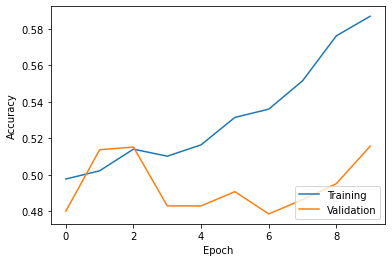

In [188]:
# Plot training, validation accuracy plots by epochs.
#   Reference: https://www.tensorflow.org/tutorials/images/cnn
plt.plot(history_rnn.history['accuracy'], label='Training')
plt.plot(history_rnn.history['val_accuracy'], label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')


In [189]:
# Evaluate the model.
X = []
for x in x_test:
    x_truncated = x[:MAX_LENGTH_CORPUS]
    
    len_padding = MAX_LENGTH_CORPUS - len(x_truncated)
    if len_padding > 0:
        x_truncated = x_truncated + [-1] * len_padding
    X.append(x_truncated)

data_generator_test = RNNWithW2VDataGenerator(
    X=X,
    y=y_test,
    batch_size=BATCH_SIZE,
    embeddings=w2v_embeddings)

_, acc_test = rnn_w2v.evaluate(
    x=data_generator_test)


24/24 [==============================] - 12s 483ms/step - loss: 0.8120 - accuracy: 0.4987


In [190]:
# Misclassified data.
X_mis = [None, None]

mis_count = 0
for i in range(len(X)):
    input_ = np.expand_dims(np.array([w2v_embeddings[idx_w] for idx_w in X[i]]), 0)
    if rnn_w2v.predict(input_)[0][0] > 0.5:
        y_pred = 1
    else:
        y_pred = 0
    if y_pred != y_test[i] and X_mis[y_test[i]] is None:
        X_mis[y_test[i]] = X[i]
        mis_count += 1
        if mis_count == len(X_mis):
            break

print("This is a negative sample classified as positive:")
print("-------------------------------------------------")
print(' '.join(get_corpus_seq([idx_w for idx_w in X_mis[0] if idx_w != -1])))
print()
print("This is a positive sample classified as negative:")
print("-------------------------------------------------")
print(' '.join(get_corpus_seq([idx_w for idx_w in X_mis[1] if idx_w != -1])))

# Comment: Apparently, my RNN model performs very badly, almost randomly. I tried countless
#   hyperparameters, both the training and validation accucacy remain around 50%. Thus,
#   I draw the conclusion that my W2V is not well-trained. In the future, I would like to try
#   out a better W2V to test my RNN model.


This is a negative sample classified as positive:
-------------------------------------------------
this movie made me think of how i could write something about it without personally the director and all the actors who as an australian i am proud of for actually getting out there and making a film br br but the movie itself let me tell you a story br br found this dvd in my local rental shop yesterday and had vague of the reviews at the time of cinema release here so i thought i would give it a go br br for some reason i decided to watch the before i watched the actual movie not something that i usually do turned the off halfway through as i'd had enough at the we so wonderful for putting together such a hard hitting film with such a raw attitude br br the movie full of clichés and pathetic character development the actors well done guys you are and i you and just like a team is only as good as the coach that directs them you unfortunately did not have a great script to work with br b

In [4]:
# 2.2. Image.

labels_map = {
    0: 'T-shirt/top',
    1: 'Trouser',
    2: 'Pullover',
    3: 'Dress',
    4: 'Coat',
    5: 'Sandal',
    6: 'Shirt',
    7: 'Sneaker',
    8: 'Bag',
    9: 'Ankle boot'
}

# Normalize pixel intensities.
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
X_train = X_train.astype('float32') / 255
X_test = X_test.astype('float32') / 255
print("The number of samples: {}".format(X_train.shape[0]))
print("The number of classes: {}".format(len(set(y_train))))


The number of samples: 60000
The number of classes: 10


In [11]:
# 2.2.1. Autoencoder

# Define an autoencoder model.
#   Reference: https://www.tensorflow.org/tutorials/generative/autoencoder.
class Autoencoder(Model):
    """
    """
    
    def __init__(self):
        super().__init__()
        self.encoder = tf.keras.Sequential(
            [layers.Flatten(),
             layers.Dense(300, activation='relu'),
             layers.Dense(100, activation='relu')],
            name="encoder")
        self.decoder = tf.keras.Sequential(
            [layers.Dense(300, activation='relu'),
             layers.Dense(784, activation='relu'),
             layers.Reshape((28, 28))])

    def call(self, X):
        X = self.encoder(X)
        X = self.decoder(X)
        return X

# Train an autoencoder.
autoencoder = Autoencoder()
autoencoder.compile(
    optimizer='adam',
    loss=tf.keras.losses.MeanSquaredError())
autoencoder.fit(
    x=X_train,
    y=X_train,
    epochs=10,
    shuffle=True,
    validation_data=(X_test, X_test))


Epoch 1/10
1875/1875 [==============================] - 10s 5ms/step - loss: 0.0241 - val_loss: 0.0177
Epoch 2/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0167 - val_loss: 0.0163
Epoch 3/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0157 - val_loss: 0.0155
Epoch 4/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0151 - val_loss: 0.0150
Epoch 5/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0147 - val_loss: 0.0147
Epoch 6/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0144 - val_loss: 0.0145
Epoch 7/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0143 - val_loss: 0.0143
Epoch 8/10
1875/1875 [==============================] - 11s 6ms/step - loss: 0.0141 - val_loss: 0.0139
Epoch 9/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0135 - val_loss: 0.0136
Epoch 10/10
1875/1875 [==============================] - 10s 5ms/step - loss: 0.

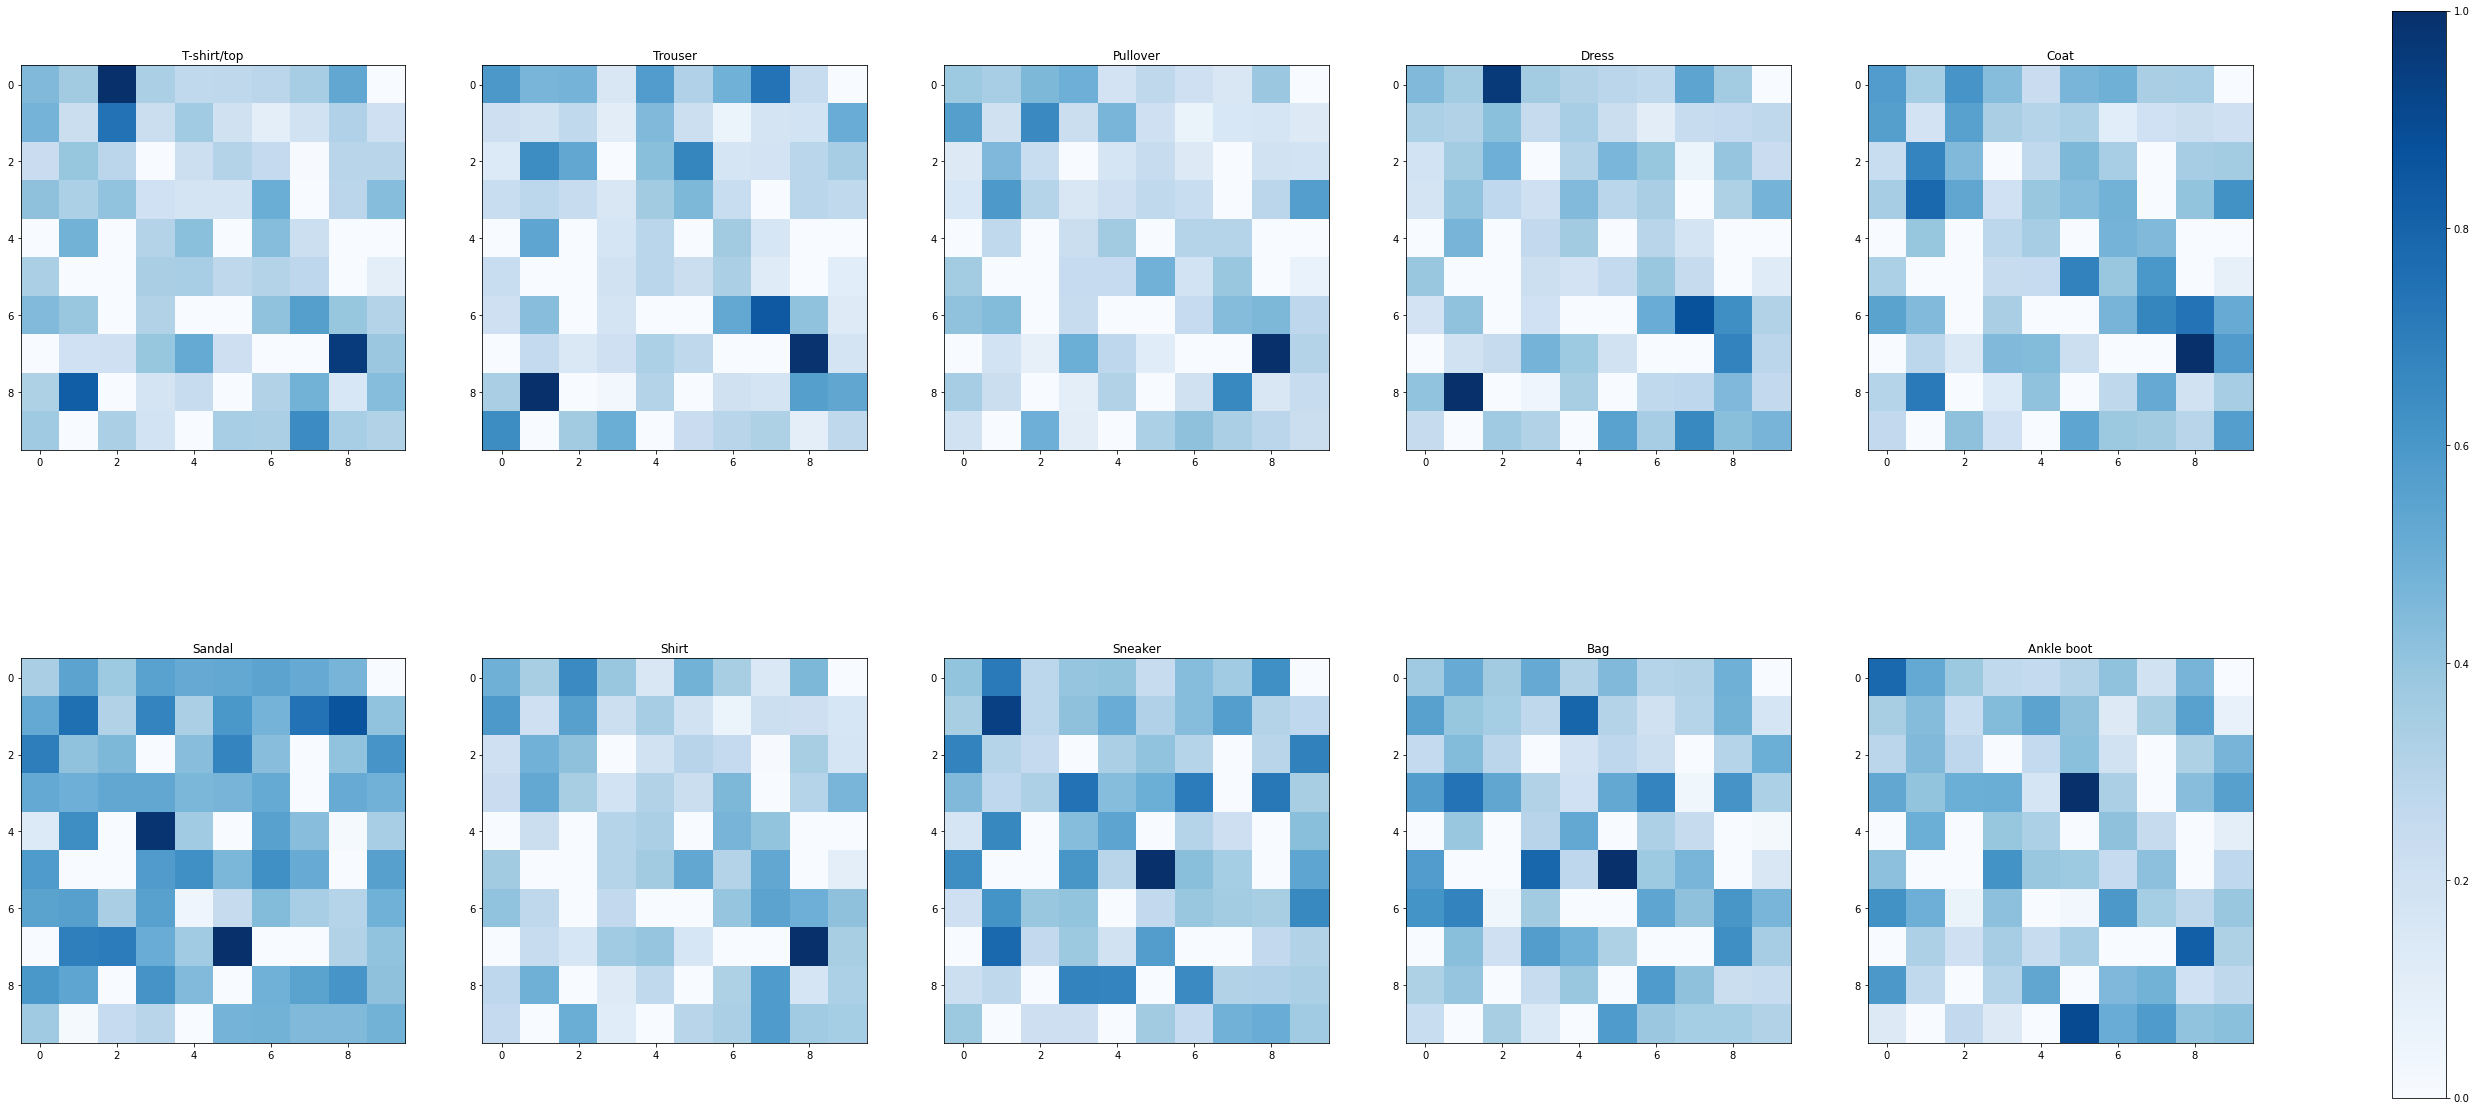

In [24]:
X_plot = [[] for _ in range(10)]
X_encoded = np.empty((10, 10, 100))

# Extract first 10 images for each class.
i = 0
while True:
    class_ = y_train[i]
    if len(X_plot[class_]) < 10:
        X_plot[class_].append(X_train[i])
    if [10] * 10 == [len(row) for row in X_plot]:
        break
    i += 1
X_plot = np.array(X_plot)

# Get typical encoded vector for each class.
for i in range(10):
    X_encoded[i] = autoencoder.encoder(X_plot[i])
X_encoded = np.mean(X_encoded, axis=1)

# Plot heatmaps 
fig, axs = plt.subplots(2, 5, figsize=(50, 20))
for i in range(10):
    axs[i // 5, i % 5].imshow(np.reshape(X_encoded[i], (10, 10)), cmap='Blues')
    axs[i // 5, i % 5].set_title(labels_map[i])
fig.colorbar(matplotlib.cm.ScalarMappable(cmap='Blues'), ax=axs.ravel().tolist())


In [26]:
# 2.2.2. Dropout.

# Define an autoencoder model with dropout.
#   Reference: https://www.tensorflow.org/tutorials/generative/autoencoder.
class AutoencoderDropout(Model):
    """
    """
    
    def __init__(self):
        super().__init__()
        self.encoder = tf.keras.Sequential(
            [layers.Flatten(),
             layers.Dense(300, activation='relu'),
             layers.Dropout(0.2),
             layers.Dense(100, activation='relu')],
            name="encoder")
        self.decoder = tf.keras.Sequential(
            [layers.Dropout(0.2),
             layers.Dense(300, activation='relu'),
             layers.Dense(784, activation='relu'),
             layers.Reshape((28, 28))])

    def call(self, X):
        X = self.encoder(X)
        X = self.decoder(X)
        return X

# Train an autoencoder.
autoencoder_dropout = AutoencoderDropout()
autoencoder_dropout.compile(
    optimizer='adam',
    loss=tf.keras.losses.MeanSquaredError())
autoencoder_dropout.fit(
    x=X_train,
    y=X_train,
    epochs=10,
    shuffle=True,
    validation_data=(X_test, X_test))


Epoch 1/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0297 - val_loss: 0.0212
Epoch 2/10
1875/1875 [==============================] - 11s 6ms/step - loss: 0.0223 - val_loss: 0.0194
Epoch 3/10
1875/1875 [==============================] - 8s 5ms/step - loss: 0.0205 - val_loss: 0.0182
Epoch 4/10
1875/1875 [==============================] - 8s 5ms/step - loss: 0.0196 - val_loss: 0.0173
Epoch 5/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0189 - val_loss: 0.0161
Epoch 6/10
1875/1875 [==============================] - 11s 6ms/step - loss: 0.0185 - val_loss: 0.0166
Epoch 7/10
1875/1875 [==============================] - 12s 7ms/step - loss: 0.0180 - val_loss: 0.0161
Epoch 8/10
1875/1875 [==============================] - 11s 6ms/step - loss: 0.0178 - val_loss: 0.0159
Epoch 9/10
1875/1875 [==============================] - 13s 7ms/step - loss: 0.0175 - val_loss: 0.0154
Epoch 10/10
1875/1875 [==============================] - 10s 6ms/step - loss:

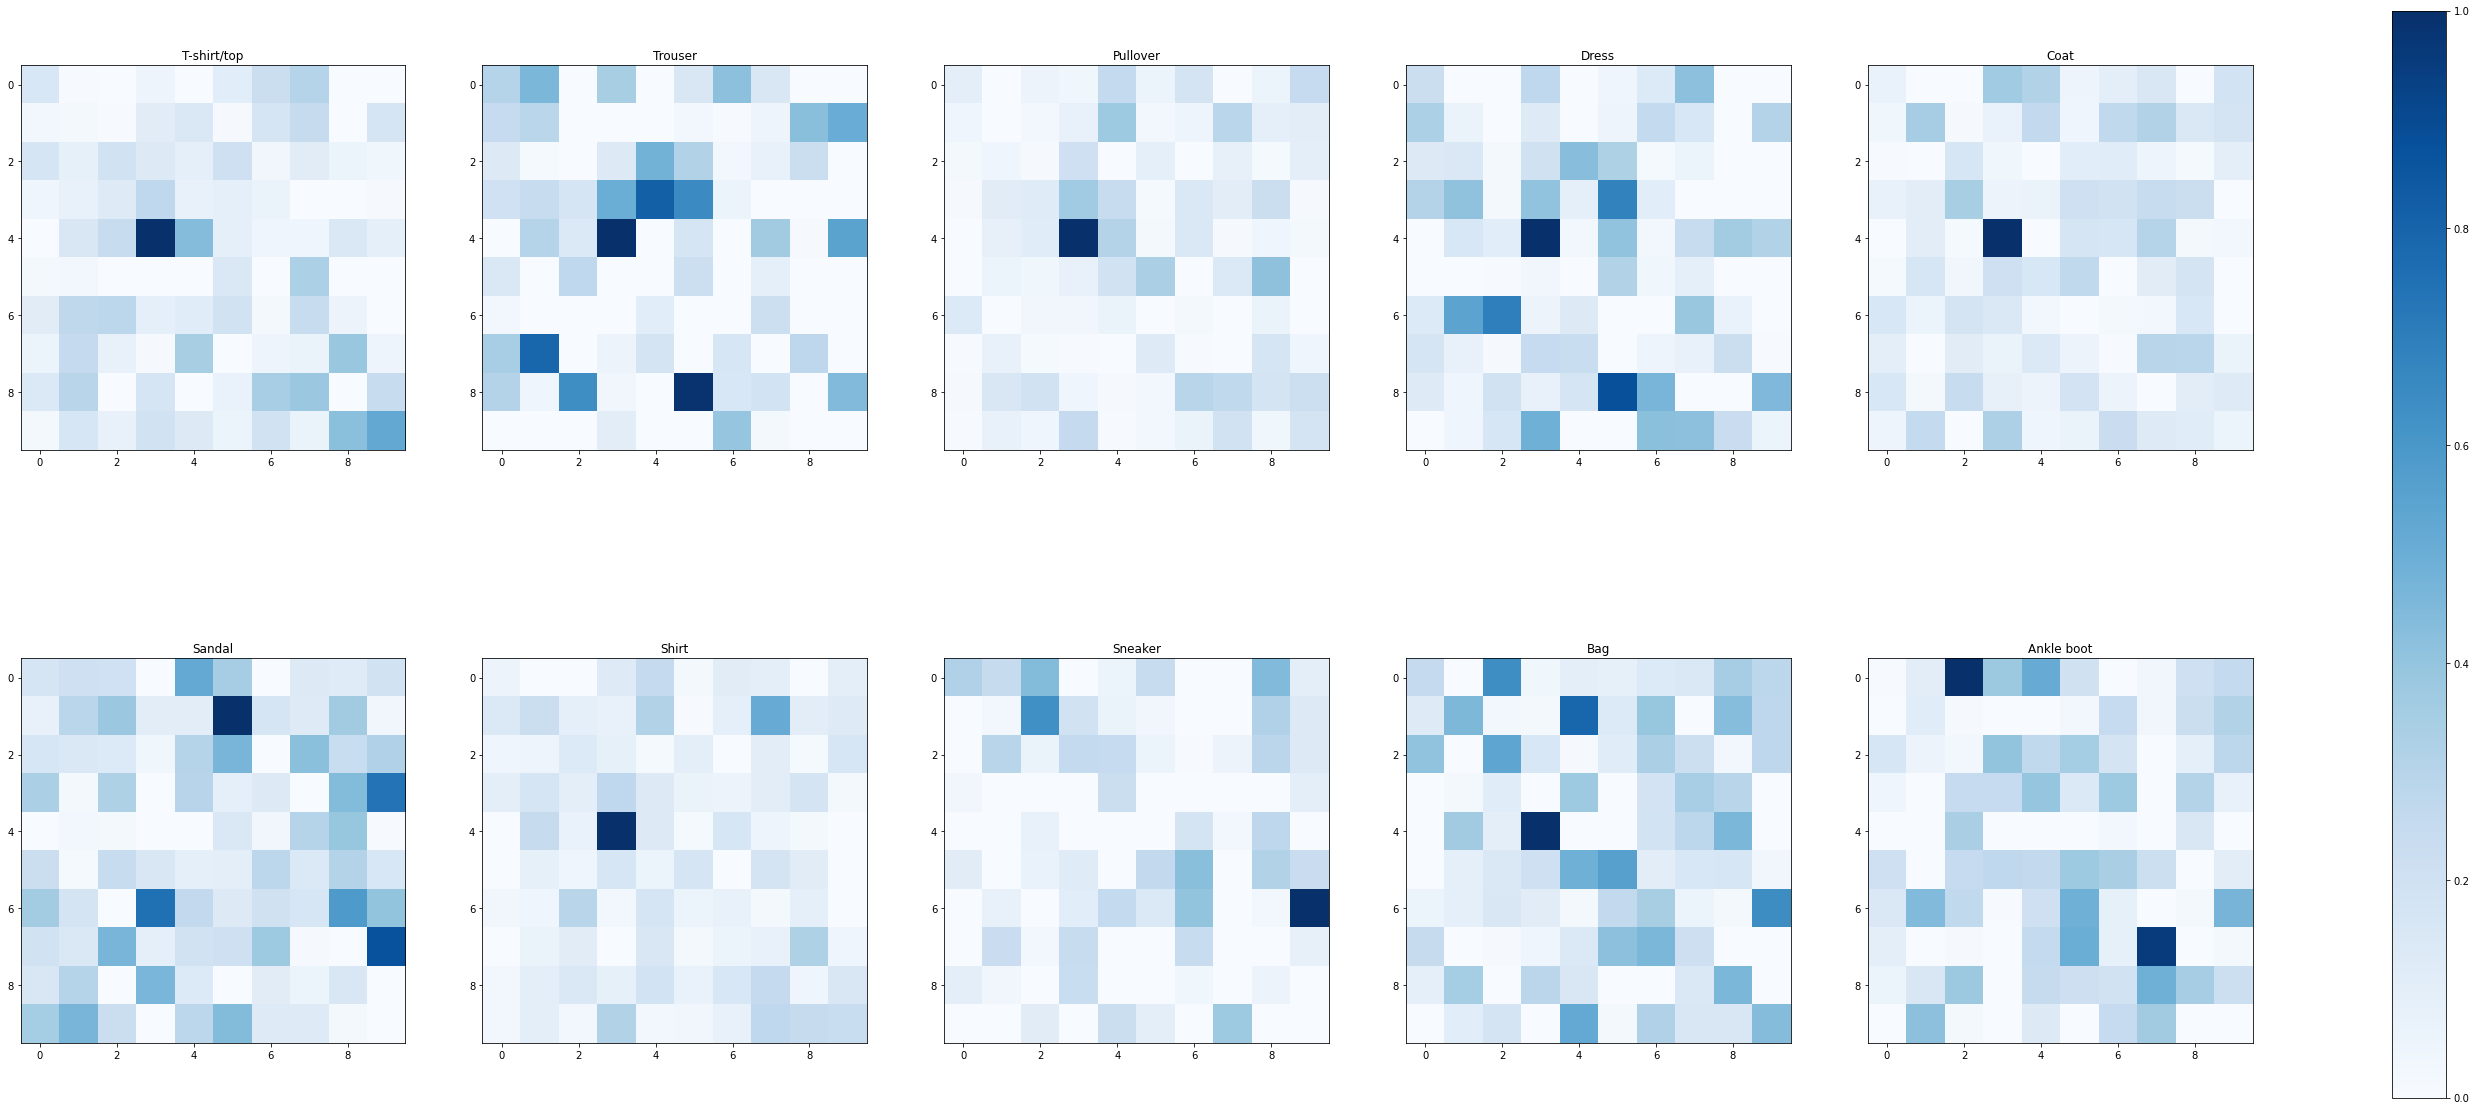

In [27]:
# Plot heatmaps.
X_encoded_dropout = np.empty((10, 10, 100))
for i in range(10):
    X_encoded_dropout[i] = autoencoder_dropout.encoder(X_plot[i], training=False)
X_encoded_dropout = np.mean(X_encoded_dropout, axis=1)
fig, axs = plt.subplots(2, 5, figsize=(50, 20))
for i in range(10):
    axs[i // 5, i % 5].imshow(np.reshape(X_encoded_dropout[i], (10, 10)), cmap='Blues')
    axs[i // 5, i % 5].set_title(labels_map[i])
# ax = fig.add_subplot(1, 6)
fig.colorbar(matplotlib.cm.ScalarMappable(cmap='Blues'), ax=axs.ravel().tolist())

# Observations: Due to the application of dropout, code layer has way less high activation values.
#   There is a particular value that is high in almost every heatmap, pixel (4, 3)


In [14]:
# 2.2.3. CNN

class CNN(Model):
    
    def __init__(self):
        super().__init__()
        self.conv_1 = layers.Conv2D(28, (3, 3), activation='relu', input_shape=(28, 28, 1))
        self.max_pooling = layers.MaxPooling2D((2, 2))
        self.conv_2 = layers.Conv2D(56, (3, 3), activation='relu')
        self.flatten = layers.Flatten()
        self.dense_1 = layers.Dense(56, activation='relu')
        self.dense_2 = layers.Dense(10, activation='softmax')

    def call(self, X):
        X = self.conv_1(X)
        X = self.max_pooling(X)
        X = self.conv_2(X)
        X = self.flatten(X)
        X = self.dense_1(X)
        return self.dense_2(X)

# Train a CNN.
cnn = CNN()
cnn.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['acc'])
history = cnn.fit(
    x=np.expand_dims(X_train, axis=3),
    y=y_train,
    batch_size=32,
    epochs=10,
    validation_split=0.2
)
cnn.summary()


Epoch 1/10
1500/1500 [==============================] - 16s 10ms/step - loss: 0.4218 - acc: 0.8483 - val_loss: 0.3160 - val_acc: 0.8845
Epoch 2/10
1500/1500 [==============================] - 15s 10ms/step - loss: 0.2784 - acc: 0.9000 - val_loss: 0.2625 - val_acc: 0.9059
Epoch 3/10
1500/1500 [==============================] - 15s 10ms/step - loss: 0.2326 - acc: 0.9141 - val_loss: 0.2423 - val_acc: 0.9126
Epoch 4/10
1500/1500 [==============================] - 15s 10ms/step - loss: 0.1990 - acc: 0.9257 - val_loss: 0.2424 - val_acc: 0.9118
Epoch 5/10
1500/1500 [==============================] - 15s 10ms/step - loss: 0.1686 - acc: 0.9379 - val_loss: 0.2378 - val_acc: 0.9151
Epoch 6/10
1500/1500 [==============================] - 15s 10ms/step - loss: 0.1460 - acc: 0.9455 - val_loss: 0.2358 - val_acc: 0.9186
Epoch 7/10
1500/1500 [==============================] - 15s 10ms/step - loss: 0.1222 - acc: 0.9537 - val_loss: 0.2521 - val_acc: 0.9174
Epoch 8/10
1500/1500 [==========================

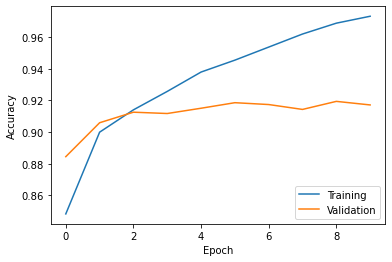

In [15]:
# Plot training, validation accuracy plots by epochs.
#   Reference: https://www.tensorflow.org/tutorials/images/cnn
acc, acc_val = history.history['acc'], history.history['val_acc']
plt.plot(history.history['acc'], label='Training')
plt.plot(history.history['val_acc'], label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')


In [28]:
# Evaluate the CNN model.
_, acc_test = cnn.evaluate(
    x=np.expand_dims(X_test, axis=3),
    y=y_test)


313/313 [==============================] - 1s 4ms/step - loss: 0.3291 - acc: 0.9115


In [44]:
# Pick a misclassified sample for each class.
X_mis = [None for _ in range(10)]
y_mis = [None for _ in range(10)]
count_mis = 0
for x, y in zip(X_test, y_test):
    y_pred = cnn.predict(np.expand_dims(x, [0, -1]))
    
    if np.argmax(y_pred[0]) != y and X_mis[y] is None:
        X_mis[y] = x
        y_mis[y] = np.argmax(y_pred[0])
        count_mis += 1
    if count_mis == len(X_mis):
        break


Text(0.5, 0.98, 'Misclassified Images')

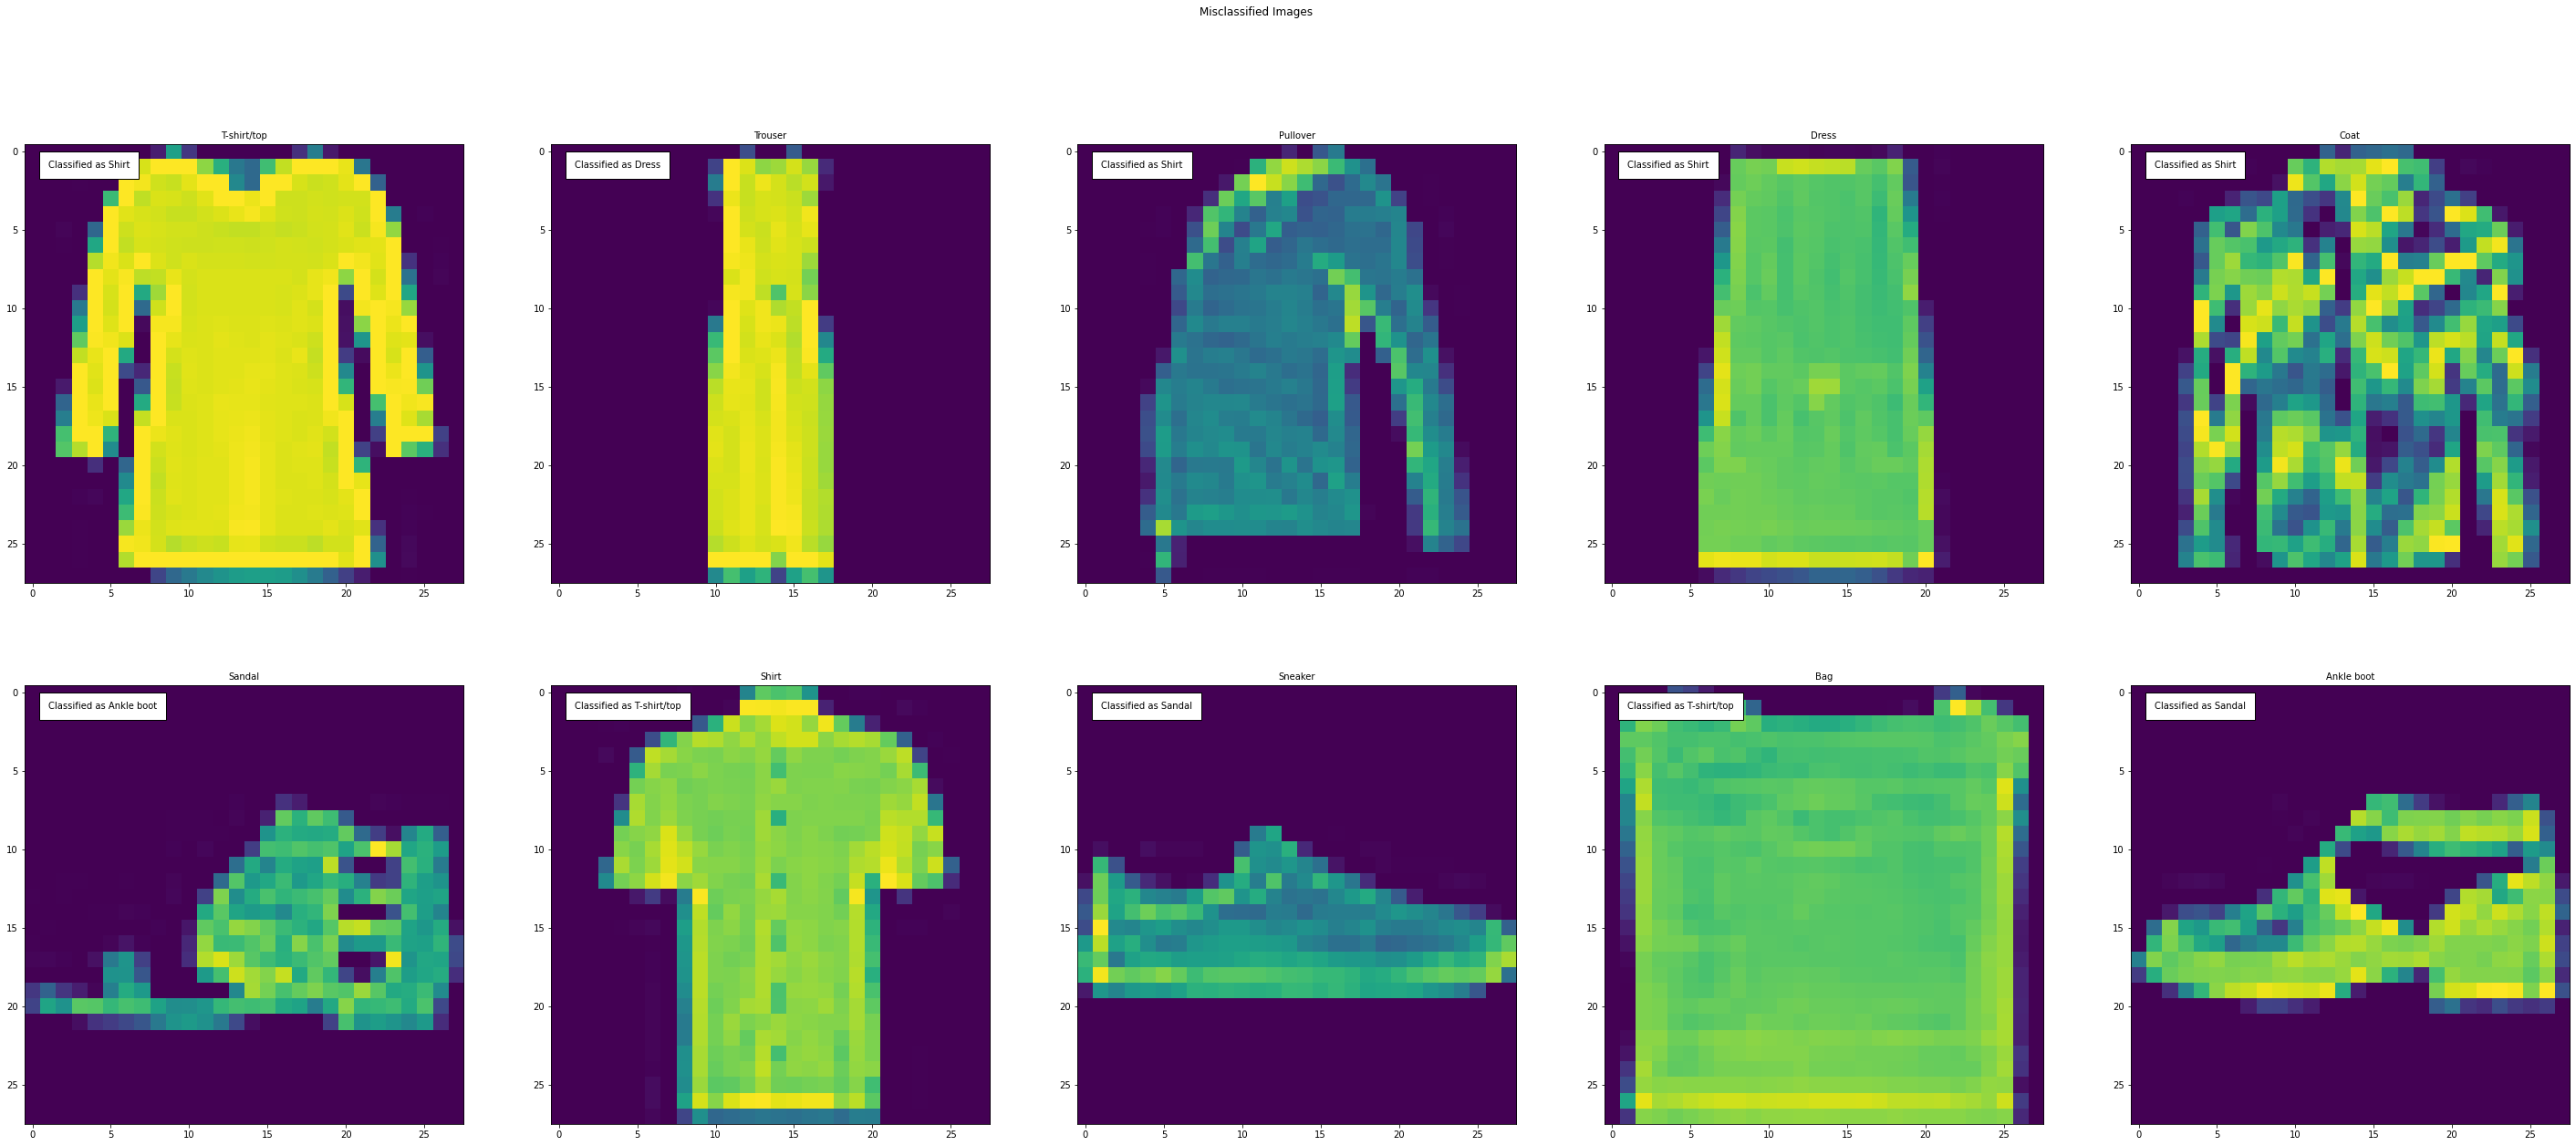

In [46]:
# Plot misclassified images.
fig, axes = plt.subplots(2, 5, figsize=(50, 20))
for i in range(len(X_mis)):
    axes[i // 5, i % 5].imshow(X_mis[i] * 255)
    axes[i // 5, i % 5].set_title(labels_map[i], fontdict={})
    axes[i // 5, i % 5].text(
        x=1,
        y=1,
        s='Classified as {}'.format(labels_map[y_mis[i]]),
        bbox={'facecolor': 'white', 'pad': 10})
fig.suptitle('Misclassified Images')

# Comment: In terms of the misclassification, we can see that different types of
#   clothes, i.e. Shirt, T-shirt, etc., are easier to be misclassified. Partially due to
#   the small sizes of each image, it is difficult to distinguish the first image and the
#   the seventh one below. In terms of the CNN model, since the validation accuracy
#   is relatively lower than the training one, the model is slightly overfitting.

In [47]:
# 2.4.4 CNN (improvements)

# Before staring, there are two observations regarding the baseline model. The first
#   observation is that the baseline has not achieved the best accuracy in training set yet.
#   This tells me that I can increase the amount of epochs.
# The second observersion is that the difference between the training accuracy and the
#   validation accuracy is about 6%. I can add a minor dropout mechanism to reduce the
#   overfitting.
# For the best result, please see the last (third) attemp.

# The first Attempt.
class CNNImproved(Model):
    
    def __init__(self):
        super().__init__()
        self.conv_1 = layers.Conv2D(28, (3, 3), activation='relu', input_shape=(28, 28, 1))
        self.max_pooling = layers.MaxPooling2D((2, 2))
        self.dropout = layers.Dropout(0.5)
        self.conv_2 = layers.Conv2D(56, (3, 3), activation='relu')
        self.flatten = layers.Flatten()
        self.dense_1 = layers.Dense(56, activation='relu')
        self.dense_2 = layers.Dense(10, activation='softmax')

    def call(self, X):
        X = self.conv_1(X)
        X = self.max_pooling(X)
        X = self.dropout(X)
        X = self.conv_2(X)
        X = self.flatten(X)
        X = self.dense_1(X)
        return self.dense_2(X)
    
cnn_imp = CNNImproved()
cnn_imp.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['acc'])
history_cnn_imp = cnn_imp.fit(
    x=np.expand_dims(X_train, axis=3),
    y=y_train,
    batch_size=32,
    epochs=15,
    validation_split=0.2
)


Epoch 1/15
1500/1500 [==============================] - 19s 13ms/step - loss: 0.4873 - acc: 0.8238 - val_loss: 0.3419 - val_acc: 0.8792
Epoch 2/15
1500/1500 [==============================] - 19s 12ms/step - loss: 0.3361 - acc: 0.8786 - val_loss: 0.2890 - val_acc: 0.8963
Epoch 3/15
1500/1500 [==============================] - 19s 13ms/step - loss: 0.2878 - acc: 0.8939 - val_loss: 0.2720 - val_acc: 0.9009
Epoch 4/15
1500/1500 [==============================] - 19s 13ms/step - loss: 0.2601 - acc: 0.9036 - val_loss: 0.2481 - val_acc: 0.9106
Epoch 5/15
1500/1500 [==============================] - 20s 14ms/step - loss: 0.2343 - acc: 0.9125 - val_loss: 0.2424 - val_acc: 0.9100
Epoch 6/15
1500/1500 [==============================] - 21s 14ms/step - loss: 0.2205 - acc: 0.9179 - val_loss: 0.2338 - val_acc: 0.9150
Epoch 7/15
1500/1500 [==============================] - 21s 14ms/step - loss: 0.2033 - acc: 0.9243 - val_loss: 0.2333 - val_acc: 0.9151
Epoch 8/15
1500/1500 [==========================

In [48]:
# Evaluate the CNN model.
# _, acc_test = cnn_imp.evaluate(
_, acc_test = cnn.evaluate(
    x=np.expand_dims(X_test, axis=3),
    y=y_test)

# Comment: The result is not significant. Although it yields a higher validation accuracy,
#   the traning accuracy has been sacrificed.


313/313 [==============================] - 1s 4ms/step - loss: 0.2540 - acc: 0.9154


In [49]:
# Now, since I am not doing cross-validation, by not training on validation data is a waste.
#   I will use the original validation data to train the model, and use the test data for
#   validation directly.

# The second attempt.
cnn_imp_2 = CNNImproved()
cnn_imp_2.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['acc'])
history_cnn_imp_2 = cnn_imp_2.fit(
    x=np.expand_dims(X_train, axis=3),
    y=y_train,
    batch_size=32,
    epochs=15,
    validation_data=(np.expand_dims(X_test, axis=3), y_test)
)

# Comment: The last epochs drop the testing accuracy greatly. The performance achieves
#   its highest point at epoch 9. Applying a large dropout seems not like a good idea, especially
#   in our case, the image size is not large.

Epoch 1/15
1875/1875 [==============================] - 23s 12ms/step - loss: 0.4675 - acc: 0.8301 - val_loss: 0.3408 - val_acc: 0.8766
Epoch 2/15
1875/1875 [==============================] - 23s 12ms/step - loss: 0.3143 - acc: 0.8841 - val_loss: 0.2937 - val_acc: 0.8922
Epoch 3/15
1875/1875 [==============================] - 25s 13ms/step - loss: 0.2720 - acc: 0.8997 - val_loss: 0.2645 - val_acc: 0.9044
Epoch 4/15
1875/1875 [==============================] - 24s 13ms/step - loss: 0.2435 - acc: 0.9090 - val_loss: 0.2507 - val_acc: 0.9081
Epoch 5/15
1875/1875 [==============================] - 24s 13ms/step - loss: 0.2255 - acc: 0.9158 - val_loss: 0.2425 - val_acc: 0.9080
Epoch 6/15
1875/1875 [==============================] - 25s 13ms/step - loss: 0.2089 - acc: 0.9219 - val_loss: 0.2465 - val_acc: 0.9107
Epoch 7/15
1875/1875 [==============================] - 25s 13ms/step - loss: 0.1929 - acc: 0.9279 - val_loss: 0.2379 - val_acc: 0.9132
Epoch 8/15
1875/1875 [==========================

In [50]:
# I will try to cut down the dropout rate from 0.5 to 0.2.

# The third attempt.
class CNNImproved2(Model):
    
    def __init__(self):
        super().__init__()
        self.conv_1 = layers.Conv2D(28, (3, 3), activation='relu', input_shape=(28, 28, 1))
        self.max_pooling = layers.MaxPooling2D((2, 2))
        self.dropout = layers.Dropout(0.2)
        self.conv_2 = layers.Conv2D(56, (3, 3), activation='relu')
        self.flatten = layers.Flatten()
        self.dense_1 = layers.Dense(56, activation='relu')
        self.dense_2 = layers.Dense(10, activation='softmax')

    def call(self, X):
        X = self.conv_1(X)
        X = self.max_pooling(X)
        X = self.dropout(X)
        X = self.conv_2(X)
        X = self.flatten(X)
        X = self.dense_1(X)
        return self.dense_2(X)
    
cnn_imp_3 = CNNImproved2()
cnn_imp_3.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['acc'])
history_cnn_imp_3 = cnn_imp_3.fit(
    x=np.expand_dims(X_train, axis=3),
    y=y_train,
    batch_size=32,
    epochs=10,
    validation_data=(np.expand_dims(X_test, axis=3), y_test))

# Comment: Almost 92%. The overfitting is diminished for a slight amount.


Epoch 1/10
1875/1875 [==============================] - 23s 12ms/step - loss: 0.4549 - acc: 0.8383 - val_loss: 0.3516 - val_acc: 0.8757
Epoch 2/10
1875/1875 [==============================] - 24s 13ms/step - loss: 0.3056 - acc: 0.8896 - val_loss: 0.2898 - val_acc: 0.8945
Epoch 3/10
1875/1875 [==============================] - 26s 14ms/step - loss: 0.2578 - acc: 0.9064 - val_loss: 0.2569 - val_acc: 0.9053
Epoch 4/10
1875/1875 [==============================] - 33s 17ms/step - loss: 0.2271 - acc: 0.9150 - val_loss: 0.2508 - val_acc: 0.9094
Epoch 5/10
1875/1875 [==============================] - 25s 13ms/step - loss: 0.2046 - acc: 0.9243 - val_loss: 0.2388 - val_acc: 0.9114
Epoch 6/10
1875/1875 [==============================] - 25s 13ms/step - loss: 0.1817 - acc: 0.9327 - val_loss: 0.2394 - val_acc: 0.9172
Epoch 7/10
1875/1875 [==============================] - 25s 13ms/step - loss: 0.1667 - acc: 0.9376 - val_loss: 0.2484 - val_acc: 0.9119
Epoch 8/10
1875/1875 [==========================